## Reference:
https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

## load data

In [1]:
# load and plot dataset
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('../data/sales-of-shampoo-over-a-three-ye.csv', 
                      header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# summarize first few rows
print(series.head())
# line plot
series.plot()
pyplot.show()

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales of shampoo over a three year period, dtype: float64


<Figure size 640x480 with 1 Axes>

In [2]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas import concat

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# load dataset

X = series.values
supervised = timeseries_to_supervised(X, 1)
print(supervised.head())

       0      0
0    0.0  266.0
1  266.0  145.9
2  145.9  183.1
3  183.1  119.3
4  119.3  180.3


In [3]:
from pandas import read_csv
from pandas import datetime
from pandas import Series

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]


# transform to be stationary
differenced = difference(series, 1)
print(differenced.head())
# invert transform
inverted = list()
for i in range(len(differenced)):
	value = inverse_difference(series, differenced[i], len(series)-i)
	inverted.append(value)
inverted = Series(inverted)
print(inverted.head())

0   -120.1
1     37.2
2    -63.8
3     61.0
4    -11.8
dtype: float64
0    145.9
1    183.1
2    119.3
3    180.3
4    168.5
dtype: float64


Using TensorFlow backend.


Month=1, Predicted=359.778603, Expected=339.700000
Month=2, Predicted=357.272357, Expected=440.400000
Month=3, Predicted=450.499666, Expected=315.900000
Month=4, Predicted=338.656637, Expected=439.300000
Month=5, Predicted=452.862817, Expected=401.300000
Month=6, Predicted=419.327654, Expected=437.400000
Month=7, Predicted=452.669678, Expected=575.500000
Month=8, Predicted=581.187796, Expected=407.600000
Month=9, Predicted=431.933507, Expected=682.000000
Month=10, Predicted=689.150541, Expected=475.300000
Month=11, Predicted=506.555680, Expected=581.300000
Month=12, Predicted=602.725027, Expected=646.900000
Test RMSE: 128.960


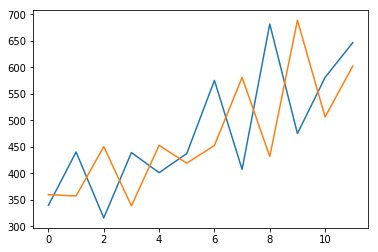

In [4]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]


# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 5, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()



In [5]:
print(raw_values)

[266.  145.9 183.1 119.3 180.3 168.5 231.8 224.5 192.8 122.9 336.5 185.9
 194.3 149.5 210.1 273.3 191.4 287.  226.  303.6 289.9 421.6 264.5 342.3
 339.7 440.4 315.9 439.3 401.3 437.4 575.5 407.6 682.  475.3 581.3 646.9]


In [6]:
print(train_scaled)

[[-0.15241435 -0.80037766]
 [-0.80037766  0.04828702]
 [ 0.04828702 -0.496628  ]
 [-0.496628    0.17669274]
 [ 0.17669274 -0.21607769]
 [-0.21607769  0.1891017 ]
 [ 0.1891017  -0.1917993 ]
 [-0.1917993  -0.32344214]
 [-0.32344214 -0.52953871]
 [-0.52953871  1.        ]
 [ 1.         -0.96493121]
 [-0.96493121 -0.10709469]
 [-0.10709469 -0.39411923]
 [-0.39411923  0.17453466]
 [ 0.17453466  0.18856218]
 [ 0.18856218 -0.59428109]
 [-0.59428109  0.3633666 ]
 [ 0.3633666  -0.48152145]
 [-0.48152145  0.26625303]
 [ 0.26625303 -0.22632857]
 [-0.22632857  0.55813326]
 [ 0.55813326 -1.        ]
 [-1.          0.26733207]]


In [7]:
print(train_reshaped)

[[[-0.15241435]]

 [[-0.80037766]]

 [[ 0.04828702]]

 [[-0.496628  ]]

 [[ 0.17669274]]

 [[-0.21607769]]

 [[ 0.1891017 ]]

 [[-0.1917993 ]]

 [[-0.32344214]]

 [[-0.52953871]]

 [[ 1.        ]]

 [[-0.96493121]]

 [[-0.10709469]]

 [[-0.39411923]]

 [[ 0.17453466]]

 [[ 0.18856218]]

 [[-0.59428109]]

 [[ 0.3633666 ]]

 [[-0.48152145]]

 [[ 0.26625303]]

 [[-0.22632857]]

 [[ 0.55813326]]

 [[-1.        ]]]


In [8]:
X, y = train[:, 0:-1], train[:, -1]
print(X)
X = X.reshape(X.shape[0], 1, X.shape[1])
print(X)

[[   0. ]
 [-120.1]
 [  37.2]
 [ -63.8]
 [  61. ]
 [ -11.8]
 [  63.3]
 [  -7.3]
 [ -31.7]
 [ -69.9]
 [ 213.6]
 [-150.6]
 [   8.4]
 [ -44.8]
 [  60.6]
 [  63.2]
 [ -81.9]
 [  95.6]
 [ -61. ]
 [  77.6]
 [ -13.7]
 [ 131.7]
 [-157.1]]
[[[   0. ]]

 [[-120.1]]

 [[  37.2]]

 [[ -63.8]]

 [[  61. ]]

 [[ -11.8]]

 [[  63.3]]

 [[  -7.3]]

 [[ -31.7]]

 [[ -69.9]]

 [[ 213.6]]

 [[-150.6]]

 [[   8.4]]

 [[ -44.8]]

 [[  60.6]]

 [[  63.2]]

 [[ -81.9]]

 [[  95.6]]

 [[ -61. ]]

 [[  77.6]]

 [[ -13.7]]

 [[ 131.7]]

 [[-157.1]]]


In [9]:
print(X.shape[1], X.shape[2])

1 1
